# Test time adaptation for a 2d Gaussian model

We use a variant of the example from eqn 2 from the NURD paper,
in which y and z are now binary, with possible values -1,+1.

Generative model:
$$
p(x|y,z) = N(x | [y-bz, y+bz], diag(1.5, 0.5))  \\
p(y) = Ber(0.5) \\
p(z|y) = \rho \text{ if $z=y$}, 1-\rho \text{ otherwise} 
$$

NURD paper:
 A. M. Puli, L. H. Zhang, E. K. Oermann, and R. Ranganath, “Out-of-distribution Generalization in the Presence of Nuisance-Induced Spurious Correlations,” in ICLR, May 2022 [Online]. Available: https://openreview.net/forum?id=12RoR2o32T. 


# Setup

In [2]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [431]:

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import einops
import matplotlib
from functools import partial
from collections import namedtuple

from numpy.random import default_rng
rng = default_rng(42)


seed = 42
key = jr.PRNGKey(seed)

import jax
import jax.random as jr
import jax.numpy as jnp
from jax import vmap, grad, jit

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

In [4]:
# Silence WARNING:root:The use of `check_types` is deprecated and does not have any effect.
# https://github.com/tensorflow/probability/issues/1523
import logging

logger = logging.getLogger()


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())

In [5]:
%load_ext autoreload
%autoreload 2

# Priors

In [453]:

nclasses = 2
nfactors = 2 # nuisance factors
nmix = nclasses * nfactors # mixture components

def yz_to_mix(y, z):
    m = jnp.ravel_multi_index((jnp.array([y]), jnp.array([z])), (nclasses, nfactors))
    return m[0]

def mix_to_yz(m):
    yz = jnp.unravel_index(m, (nclasses, nfactors))
    return yz[0], yz[1]




In [458]:
ys, zs = vmap(mix_to_yz)(jnp.array([0,1,2,3]))
print(ys)
print(zs)

[0 0 1 1]
[0 1 0 1]


In [454]:
for y in range(nclasses):
  for z in range(nfactors):
    m = yz_to_mix(y, z)
    (yy, zz) = mix_to_yz(m)
    print('y={:d},z={:d} -> m={:d} -> y=={:d}, z=={:d}'.format(y, z, m, yy, zz))

y=0,z=0 -> m=0 -> y==0, z==0
y=0,z=1 -> m=1 -> y==0, z==1
y=1,z=0 -> m=2 -> y==1, z==0
y=1,z=1 -> m=3 -> y==1, z==1


In [8]:
# DEPRECATED
def make_priors(rho):
    p_class =  np.array([0.5, 0.5]) # uniform prior  on p(y) = (-1, +1)
    p_factor_given_class = np.zeros((2, 2))  # p(z|c) = p_factor(c,z) so each row sums to 1
    p_factor_given_class[0, :] = [1 - rho, rho]
    p_factor_given_class[1, :] = [rho, 1 - rho]
    p_mix = np.zeros((nclasses, nfactors))  # (c,z)
    for c in range(nclasses):
        for z in range(nfactors):
            p_mix[c, z] = p_class[c] * p_factor_given_class[c, z]
    return p_class, p_factor_given_class, p_mix

p_class, p_factor_given_class, p_mix = make_priors(0.1)
print(p_class)
print(p_factor_given_class)
print(p_mix)


[0.5 0.5]
[[0.9 0.1]
 [0.1 0.9]]
[[0.45 0.05]
 [0.05 0.45]]


In [76]:
def make_mix_prior(rho):
    p_class =  np.array([0.5, 0.5]) # uniform prior  on p(y) = (-1, +1)
    p_factor_given_class = np.zeros((2, 2))  # p(z|c) = p_factor(c,z) so each row sums to 1
    p_factor_given_class[0, :] = [1 - rho, rho]
    p_factor_given_class[1, :] = [rho, 1 - rho]
    p_mix = np.zeros((nclasses, nfactors))  # (c,z)
    for c in range(nclasses):
        for z in range(nfactors):
            p_mix[c, z] = p_class[c] * p_factor_given_class[c, z]
    p_mix = einops.rearrange(p_mix, 'y z -> (y z)')
    return p_mix

In [438]:


params = {'b': 1, 'sf': 1, 'rho': 0.1}
print(params)

{'b': 1, 'sf': 1, 'rho': 0.1}


In [439]:
mix_prior_source = make_mix_prior(params['rho'])

#  Likelihood

In [436]:
# We use the NURD model from sec 2 of https://arxiv.org/abs/2107.00520
# Generative model: p(x|y,z) = N(x | [y-bz, y+bz], diag(1.5, 0.5)) 
# They assume b=1

#from scipy.stats import multivariate_normal

def class_cond_density(y, z, b, sf):  # p(x|y,z)
    # convert from (0,1) to (-1,1)
    ysigned = 2.0*y-1
    zsigned = 2.0*z-1
    mu = jnp.array([ysigned - b*zsigned, ysigned + b*zsigned])
    Sigma = sf*jnp.diag(jnp.array([1.5, 0.5]))
    dist = tfd.MultivariateNormalFullCovariance(loc=mu, covariance_matrix=Sigma)
    #dist = multivariate_normal(mean=mu, cov=Sigma, seed=seed)
    return dist


def mix_lik_source(m, xs, b=params['b'], sf=params['sf']):
  # return p(n) = p(xs(n) | m=(y,z))
  (y, z) = mix_to_yz(m)
  dist = class_cond_density(y, z, b, sf)
  #return dist.pdf(xs) # scipy
  return dist.prob(xs) # tfd

def class_cond_density_source(m, b=params['b'], sf=params['sf']):
  (y, z) = mix_to_yz(m)
  return class_cond_density(y, z, b, sf)


In [435]:

dist = class_cond_density(0, 1, b=1, sf=1)
print(dist)

xs = np.array([[-1, 2], [0.1, 3], [0.1, 3]])
print(mix_lik_source(0, xs))



tfp.distributions.MultivariateNormalFullCovariance("MultivariateNormalFullCovariance", batch_shape=[], event_shape=[2], dtype=float32)
[1.4818809e-08 2.5437833e-12 2.5437833e-12]


# Posterior

In [401]:

def normalize_probs(probs):
  # make each row sum to 1. Also works for multi-dim distributions eg 3d
    #S = einops.rearrange(probs, "i ... -> i (...)").sum(axis=-1)
    S = einops.reduce(probs, "i ... -> i", "sum")
    probs = np.einsum("i...,i->i...", probs, 1 / S)
    return probs
    



In [319]:
A = np.array([ [1,2,3,4], [5,6,7,8]])
AA = normalize_probs(A)
print(A)
print(np.sum(AA, axis=1))

B = np.reshape(A, (2, 2, 2))
BB = normalize_probs(B)
print(B)
print(np.sum(BB, axis=(1,2)))

[[1 2 3 4]
 [5 6 7 8]]
[1. 1.]
[[[1 2]
  [3 4]]

 [[5 6]
  [7 8]]]
[1. 1.]


In [185]:

def compute_mix_post(xs, mix_prior, mix_lik):  # Bayes rule using generative model
    ndata = len(xs)
    nmix = 4
    mix_post = np.zeros((ndata, nmix))
    for m in range(nmix):
        mix_post[:, m] = mix_prior[m] * mix_lik(m, xs)
    mix_post = normalize_probs(mix_post)
    return mix_post

def compute_class_post(mix_post):
  #ndata = mix_post.shape[0]
  #mix_post = np.reshape(mix_post, (ndata, nclasses, nfactors))
  mix_post = einops.rearrange(mix_post, 'n (y z) -> n y z', y=nclasses, z=nfactors)
  class_post = einops.reduce(mix_post, 'n y z -> n y', 'sum') 
  return class_post 


In [19]:
def make_xgrid(npoints = 100):
    npoints = npoints * 1j
    xyrange = jnp.array([[-3, 3], [-3, 3]])
    mesh = jnp.mgrid[xyrange[0, 0] : xyrange[0, 1] : npoints, xyrange[1, 0] : xyrange[1, 1] : npoints]
    x1, x2 = mesh[0], mesh[1]
    points = jnp.vstack([jnp.ravel(x1), jnp.ravel(x2)]).T
    return points, x1, x2


In [320]:


xs, x1, x2 = make_xgrid(npoints = 100)
mix_prior = make_mix_prior(0.1)
print(mix_prior.shape)
mix_post = compute_mix_post(xs, mix_prior, partial(mix_lik_source, b=1, sf=1))
print(mix_post.shape)
class_post = compute_class_post(mix_post)
print(class_post.shape)

(4,)
(10000, 4)
(10000, 2)


# Plotting class conditional densities

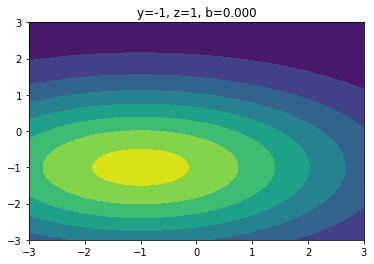

In [321]:
def plot_class_cond_dist(y, z, b, sf, fig=None, ax=None):
    if fig is None:
        fig, ax = plt.subplots()
    dist = class_cond_density(y, z, b, sf)
    
    # convert from (0,1) to (-1,1)
    ysigned = 2*y-1
    zsigned = 2*z-1

    points, x1, x2 = make_xgrid(100)
    #p = dist.pdf(points).reshape(x1.shape[0], x2.shape[0])
    p = dist.prob(points).reshape(x1.shape[0], x2.shape[0])
    contour = ax.contourf(x1, x2, p)
    #cbar = fig.colorbar(contour, ax=ax)
    ax.set_title('y={:d}, z={:d}, b={:0.3f}'.format(ysigned, zsigned, b))


plot_class_cond_dist(0, 1, b=0, sf=5)

In [256]:
def plot_class_cond_dist_all(b, sf):
    fig, ax = plt.subplots(2, 2, figsize=(10,10))
    for y in [0,1]:
        for z in [0,1]:
            plot_class_cond_dist(y, z, b, sf, fig, ax[y,z])
        

  

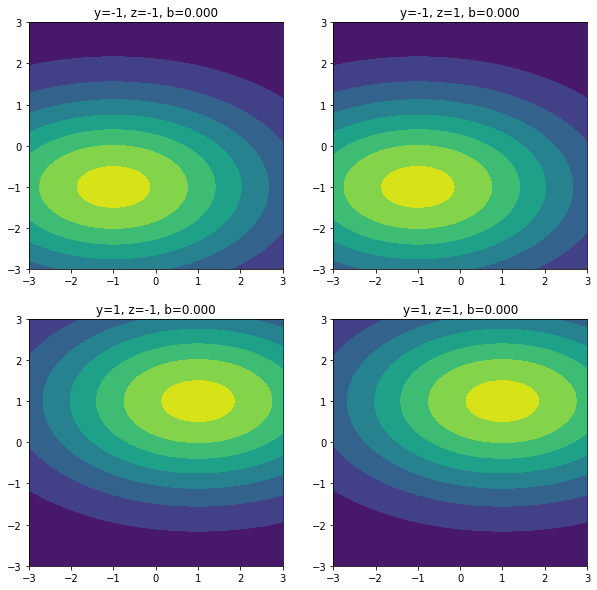

In [322]:
plot_class_cond_dist_all(b=0, sf=5) # effect of z is ignored if b=0

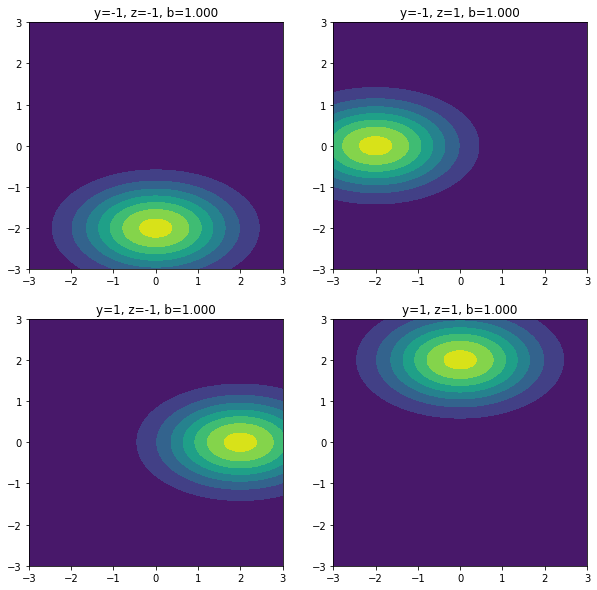

In [258]:
plot_class_cond_dist_all(b=1, sf=1)

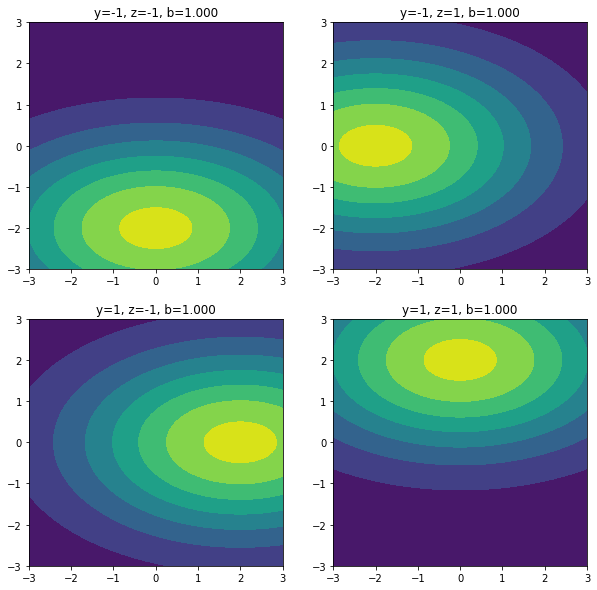

In [222]:
plot_class_cond_dist_all(b=1, sf=5)

# Plotting posteriors


In [26]:
def plot_class_post_heatmap(xs, post):
    ndata = xs.shape[0]
    ngrid = int(np.sqrt(ndata))
    x1 = np.reshape(xs[:,0], [ngrid, ngrid])
    x2 = np.reshape(xs[:,1], [ngrid, ngrid])
    fig, ax = plt.subplots()
    post2d = np.reshape(class_post[:, 0], [ngrid, ngrid])
    contour = ax.contourf(x1, x2, post2d)
    cbar = fig.colorbar(contour, ax=ax)

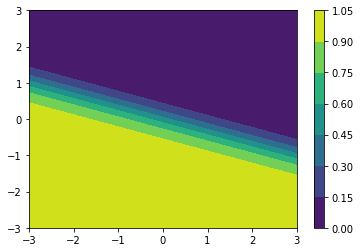

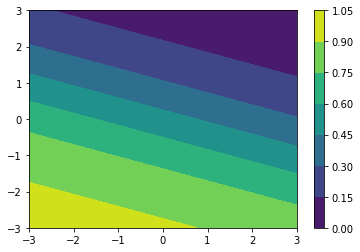

In [437]:
# When we have 2 gaussians with equal covariance, one per class, the decision boundary is linear
# as in LDA, but the sharpness depends on degree of overlap (covariance sf)


xs, x1, x2 = make_xgrid(npoints = 100)
mix_prior = make_mix_prior(0.1)
mix_post = compute_mix_post(xs, mix_prior, partial(mix_lik_source, b=0, sf=1))
class_post = compute_class_post(mix_post)
plot_class_post_heatmap(xs, class_post)

mix_post = compute_mix_post(xs, mix_prior, partial(mix_lik_source, b=0, sf=5))
class_post = compute_class_post(mix_post)
plot_class_post_heatmap(xs, class_post)

In [265]:
def plot_class_post_points(xs, post, fig=None, ax=None, ttl=None):
    x = xs[:,0]
    y = xs[:,1]
    z = post[:,0]
    if fig is None:
        fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=100)
    norm = matplotlib.colors.Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm = norm), ax=ax)
    if ttl is not None:
      ax.set_title(ttl)
    


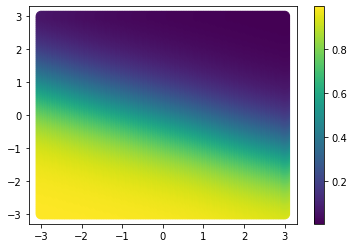

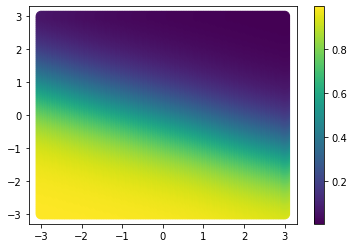

In [324]:
# When b=0 the z variable is ignored, so decision boundary is NW-SE diagonal
# Changing the prior correlation moves the decision boundary along SW-NE
# However, the likelihood needs to be weak (large scale factor on coavriance)
# for this effect to be visible

xs, x1, x2 = make_xgrid(npoints = 100)
mix_prior = make_mix_prior(0.1)
mix_post = compute_mix_post(xs, mix_prior, partial(mix_lik_source, b=0, sf=3))
class_post = compute_class_post(mix_post)
plot_class_post_points(xs, class_post)


mix_prior = make_mix_prior(0.9)
mix_post = compute_mix_post(xs, mix_prior, partial(mix_lik_source, b=0, sf=3))
class_post = compute_class_post(mix_post)
plot_class_post_points(xs, class_post)

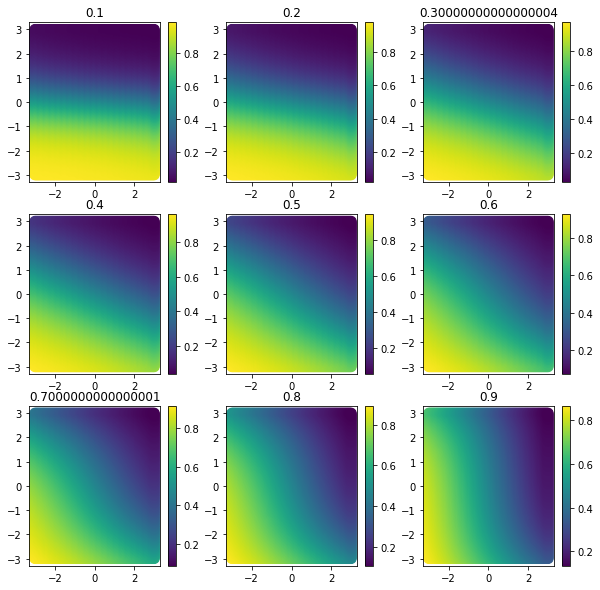

In [275]:
# When b=1, x depends on y and z, so decision boundary depends on rho

xs, x1, x2 = make_xgrid(npoints = 100)
rhos = np.linspace(0.1, 0.9, num=9)
fig, axs = plt.subplots(3, 3, figsize=(10,10))
axs = axs.reshape(-1)
for i in range(9):
    rho = rhos[i]
    ax = axs[i]
    mix_prior = make_mix_prior(rho)
    mix_post = compute_mix_post(xs, mix_prior, partial(mix_lik_source, b=1, sf=5))
    class_post = compute_class_post(mix_post)
    plot_class_post_points(xs, class_post, fig=fig, ax=ax)
    ax.set_title(rho)

# Train classifier on grid

In [325]:
# Generate training data
# We evaluate p(m|x) on a grid of N points using the true model,
# then sample a mixture label for each point to get (xn, mn) training pairs


X_train_grid, x1, x2 = make_xgrid(npoints = 100)
ntrain = X_train_grid.shape[0]
mix_post_true_grid = compute_mix_post(X_train_grid, mix_prior_source, mix_lik_source)
mix_label_train_grid =  jr.categorical(key, logits=jnp.log(mix_post_true_grid))

# show some sample labels and the predictive probabilities
ndx = np.round(np.linspace(1, ntrain-1, num=100)).astype(int)
print(mix_label_train_grid[ndx])
#print(mix_post_true_grid[ndx,:])



[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 3 0 0 0 0 0 3 0 0 0 0 0 2 1
 0 2 0 0 0 0 0 0 0 3 3 3 0 0 3 0 0 0 0 2 2 3 0 3 3 1 0 3 3 3 1 3 1 3 3 3 3
 3 3 0 2 0 3 3 3 0 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3]


In [277]:
def plot_mix_post(mix_post, nmax=100, ttl=None):
  ntrain, nmix = mix_post.shape
  # select a subset of points to plot
  n = np.min([ntrain, nmax])
  ndx = np.round(np.linspace(1, ntrain-1, num=n)).astype(int)
  colors = ['r', 'g', 'b', 'k']
  plt.figure()
  for m in range(nmix):
    y, z = mix_to_yz(m)
    plt.plot(mix_post[ndx,m], colors[m], label='m={:d},y={:d},z={:d}'.format(m,y,z))
  plt.legend()
  if ttl is not None:
    plt.title(ttl)

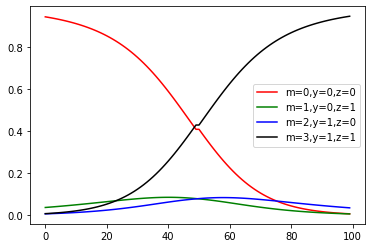

In [278]:
plot_mix_post(mix_post_true_grid)

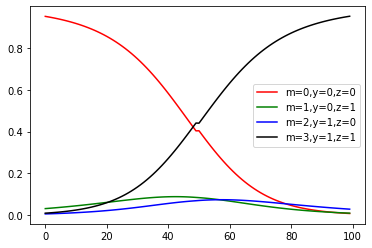

In [279]:
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression


classifier_grid = Pipeline([('poly', PolynomialFeatures(degree=2)), 
                       ('logreg', LogisticRegression(random_state=0))])
classifier_grid.fit(X_train_grid, mix_label_train_grid)

# Predict on the training set
mix_post_pred_grid = classifier_grid.predict_proba(X_train_grid)

plot_mix_post(mix_post_pred_grid)

In [280]:
def compare_mix_post(mix_post1, mix_post2, nmax=100):
  ntrain, nmix = mix_post1.shape
  colors = ['r', 'g', 'b', 'k']
  fig, axs = plt.subplots(2, 2, figsize=(10,10))
  axs = axs.reshape(-1)
  # select a subset of points to plot
  n = np.min([ntrain, nmax])
  ndx = np.round(np.linspace(1, ntrain-1, num=n)).astype(int)
  for m in range(nmix):
    ax = axs[m]
    ax.plot(mix_post1[ndx,m], color=colors[m], ls='-', label='m={:d}, method 1'.format(m))
    ax.plot(mix_post2[ndx,m], color=colors[m], ls=':', label='m={:d}, method 2'.format(m))
    ax.legend()


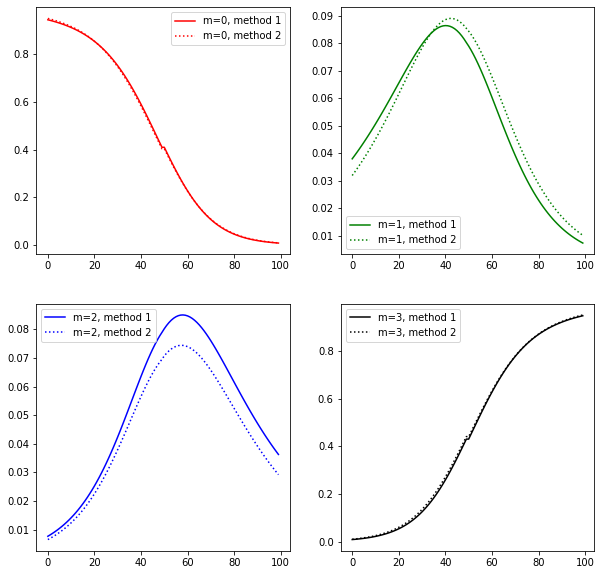

In [281]:
compare_mix_post(mix_post_true_grid, mix_post_pred_grid)

# Train classifier on random samples

In [326]:
def sample_data(key, mix_prior, ntrain):
  labels =  jr.categorical(key, logits=jnp.log(mix_prior), shape=(ntrain,))
  ndim = 2
  X = np.zeros((ntrain, ndim))
  nmix = 4
  for m in range(nmix):
    ndx = np.nonzero(labels==m)[0]
    dist = class_cond_density_source(m)
    xs = dist.sample(seed=key, sample_shape=len(ndx))  
    X[ndx, :] = xs
  return X, labels

In [446]:
X_train, mix_train = sample_data(jr.PRNGKey(42), mix_prior_source, 500)

print(X_train.shape)
print(mix_train.shape)

ntrain = X_train.shape[0]
n = np.min([ntrain, 10])
ndx = np.round(np.linspace(1, ntrain-1, num=n)).astype(int)

print(X_train[ndx])
print(mix_train[ndx])

(500, 2)
(500,)
[[-0.69344109 -2.52777982]
 [-1.12092292 -1.95809865]
 [-1.99418712 -1.67337656]
 [ 3.27447057  0.57432437]
 [ 0.34215295 -1.91887772]
 [ 1.21611905 -0.5195815 ]
 [ 0.96468222 -1.21641517]
 [ 0.86976182  0.76760304]
 [-3.10489845  1.07038832]
 [ 0.50583404  0.49537909]]
[0 0 0 2 0 2 0 3 1 3]


In [460]:
# compute mixture posterior on some of the sampled data
# then derive the MAP estimate for the mix labels
# this should be similar to the sampled mix labels
mix_post_true = compute_mix_post(X_train[ndx], mix_prior_source, mix_lik_source)
mix_hat = np.argmax(mix_post_true, axis=1)
print(mix_hat)

# derive class posterior and MAP class labels
# compare to the result derived from the MAP mix labels
class_post_true = compute_class_post(mix_post_true)
#print(np.sum(class_post_true, axis=1))
class_hat = np.argmax(class_post_true, axis=1)
print(class_hat)

ys, zs = vmap(mix_to_yz)(mix_hat)
print(ys)


[0 0 0 2 0 2 0 3 1 3]
[0 0 0 1 0 0 0 1 0 1]
[0 0 0 1 0 1 0 1 0 1]


In [461]:

classifier = Pipeline([('poly', PolynomialFeatures(degree=2)), 
                       ('logreg', LogisticRegression(random_state=0, max_iter=100))])

classifier.fit(X_train, mix_train)

Pipeline(steps=[('poly', PolynomialFeatures()),
                ('logreg', LogisticRegression(random_state=0))])

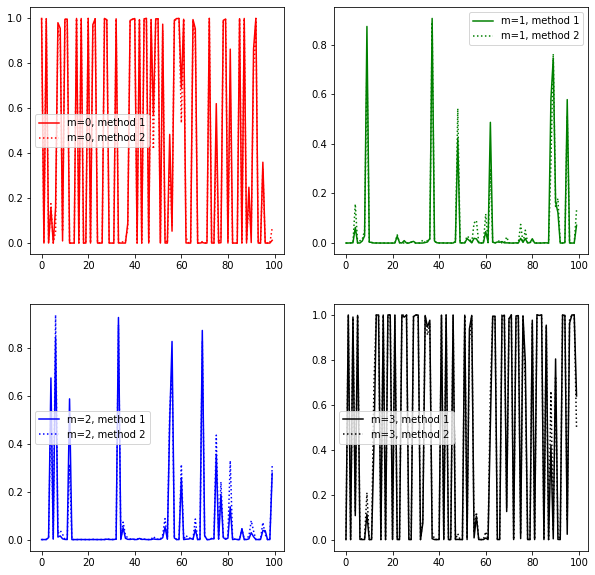

In [462]:
# Evaluate on training set

mix_post_true = compute_mix_post(X_train, mix_prior_source, mix_lik_source)
mix_post_pred = classifier.predict_proba(X_train)

compare_mix_post(mix_post_true, mix_post_pred)

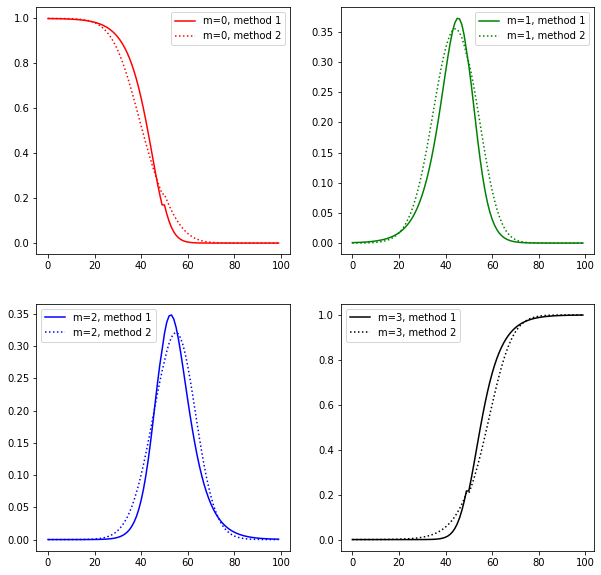

In [463]:
# Evaluate on test grid
xs, x1, x2 = make_xgrid(npoints = 100)

mix_post_learned = classifier.predict_proba(xs)
mix_post_true = compute_mix_post(xs, mix_prior_source, mix_lik_source)

compare_mix_post(mix_post_true, mix_post_learned)

# Calibration

In [334]:
# https://scikit-learn.org/stable/modules/calibration.html#calibrating-a-classifier
from sklearn.calibration import CalibratedClassifierCV

X_valid, mix_valid = sample_data(jr.PRNGKey(43), mix_prior_source, 500)

classifier_cal = CalibratedClassifierCV(classifier, method="sigmoid", cv="prefit")
classifier_cal.fit(X_valid, mix_valid)

CalibratedClassifierCV(base_estimator=Pipeline(steps=[('poly',
                                                       PolynomialFeatures()),
                                                      ('logreg',
                                                       LogisticRegression(random_state=0))]),
                       cv='prefit')

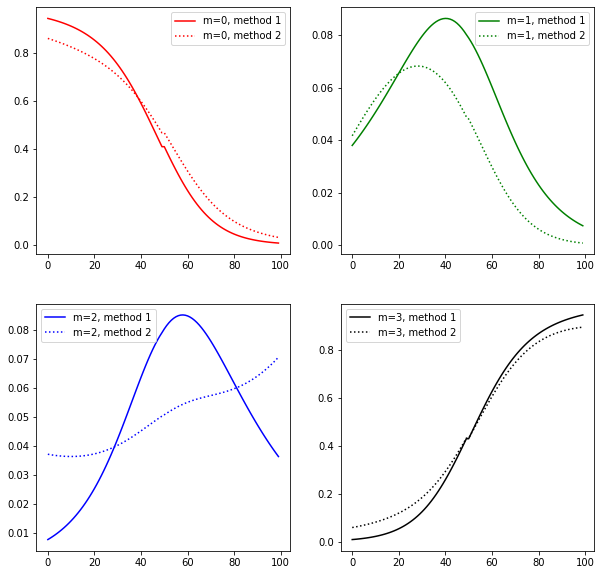

In [381]:
xs, x1, x2 = make_xgrid(npoints = 100)
mix_post_learned = classifier_cal.predict_proba(xs)
mix_post_true = compute_mix_post(xs, mix_prior_source, mix_lik_source)

compare_mix_post(mix_post_true, mix_post_learned)

# Derive generative model from classifier

In [134]:
def mix_lik_learned(m, xs):
  #, classifier, mix_prior_source):
  # return p(n) = p_s(x(n) | m) = p_s(m|x) p_s(x) / p_s(m) propto p_s(m|x) / p_s(m)
  n = xs.shape[0]
  probs = classifier.predict_proba(xs)[:,m] / mix_prior_source[m]
  return probs

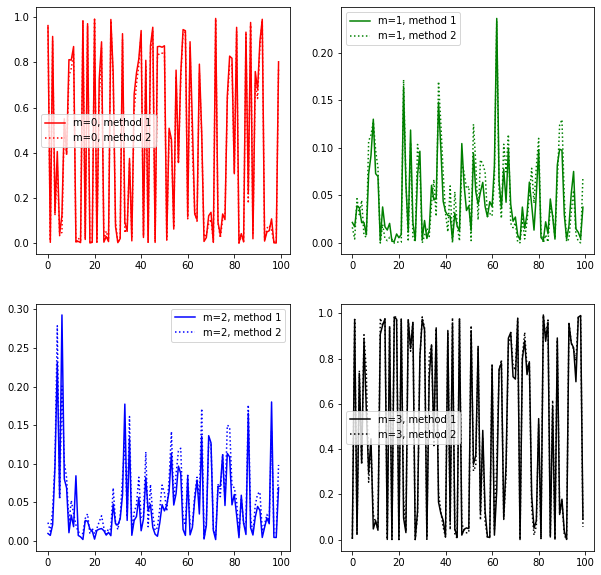

In [332]:


mix_post_learned = compute_mix_post(X_train, mix_prior_source, mix_lik_learned)
mix_post_true = compute_mix_post(X_train, mix_prior_source, mix_lik_source)

compare_mix_post(mix_post_true, mix_post_learned)

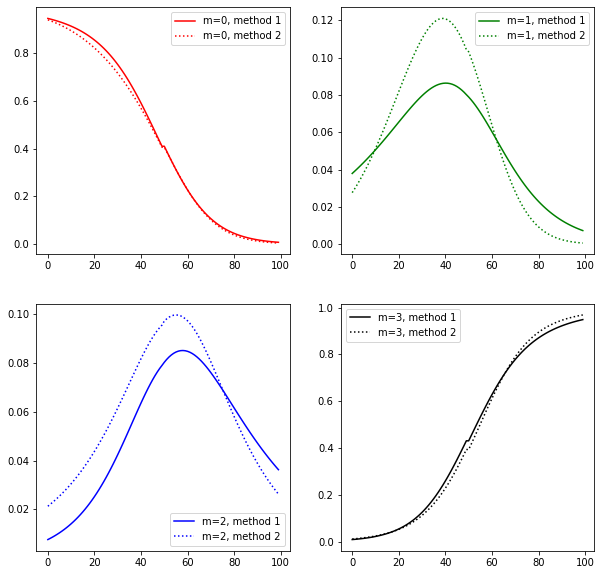

In [333]:


xs, x1, x2 = make_xgrid(npoints = 100)

mix_post_learned = compute_mix_post(xs, mix_prior_source, mix_lik_learned)
mix_post_true = compute_mix_post(xs, mix_prior_source, mix_lik_source)

compare_mix_post(mix_post_true, mix_post_learned)

# Distribution shift

In [357]:
def compare_class_post_points(xs, post_true, post_pred, fig=None, ax=None, ttl=None):
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    #err = evaluate_class_post(class_post_true, class_post_pred)
    plot_class_post_points(xs, class_post_true, fig, ax=axs[0], ttl='true')
    plot_class_post_points(xs, class_post_pred, fig, ax=axs[1], ttl='pred')


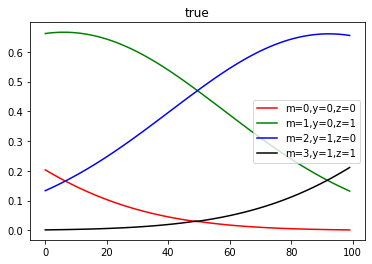

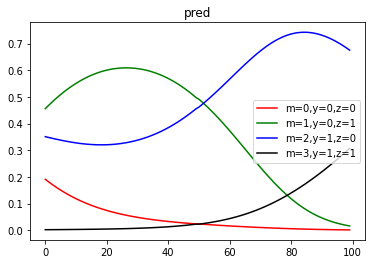

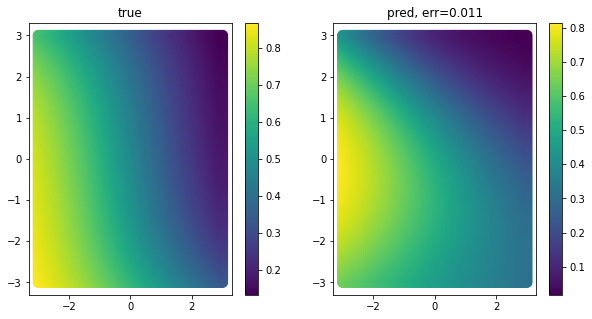

In [352]:
mix_prior_target_true = make_mix_prior(0.9)

xs, x1, x2 = make_xgrid(npoints = 100)


mix_post_true = compute_mix_post(xs, mix_prior_target_true, mix_lik_source)
mix_post_pred = compute_mix_post(xs, mix_prior_target_true, mix_lik_learned)

plot_mix_post(mix_post_true, ttl='true')
plot_mix_post(mix_post_pred,  ttl='pred')

class_post_true = compute_class_post(mix_post_true)
class_post_pred = compute_class_post(mix_post_pred)


#plot_class_post_points(xs, class_post_true, ttl='true')
#plot_class_post_points(xs, class_post_pred, ttl='predicted')

compare_class_post_points(xs, class_post_true, class_post_pred)


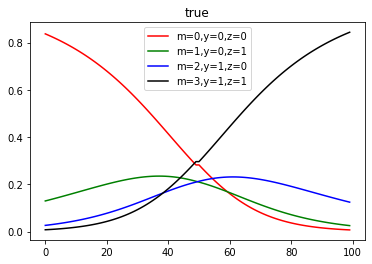

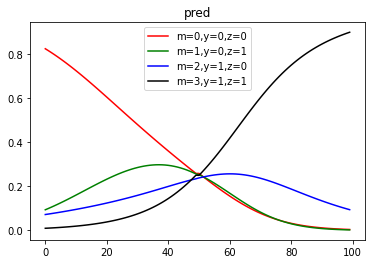

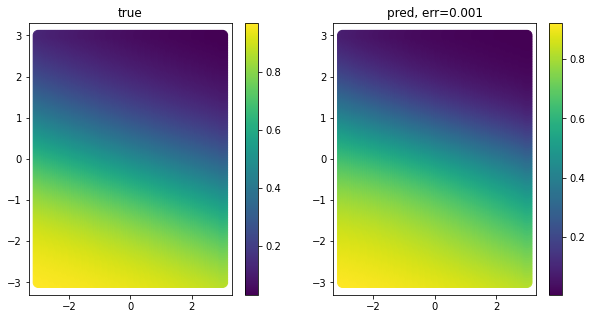

In [353]:
mix_prior_target_true = make_mix_prior(0.3)

xs, x1, x2 = make_xgrid(npoints = 100)


mix_post_true = compute_mix_post(xs, mix_prior_target_true, mix_lik_source)
mix_post_pred = compute_mix_post(xs, mix_prior_target_true, mix_lik_learned)

plot_mix_post(mix_post_true, ttl='true')
plot_mix_post(mix_post_pred,  ttl='pred')

class_post_true = compute_class_post(mix_post_true)
class_post_pred = compute_class_post(mix_post_pred)

compare_class_post_points(xs, class_post_true, class_post_pred)

# EM

In [428]:
def em(Xtarget, init_dist, niter=10, pseudo_counts=np.zeros(4), mix_lik_fn = mix_lik_learned):
  target_dist = init_dist
  ndata = Xtarget.shape[0]
  nmix = 4
  post = np.zeros((ndata, nmix))
  for t in range(niter):
    print(f'EM iter {t}')
    #print(target_dist)
    # E step
    for m in range(nmix):
      post[:, m] = mix_lik_fn(m, Xtarget) * target_dist[m] 
    post = normalize_probs(post)
    # M step
    ncounts = np.zeros(nmix)
    for m in range(nmix):
      ncounts[m] = np.sum(post[:, m]) + pseudo_counts[m]
    target_dist = ncounts / np.sum(ncounts)
  return target_dist

In [424]:

def est_empirical_mix_dist(labels):
  nmix = 4
  ndata = len(labels)
  counts = np.zeros(nmix)
  for m in range(nmix):
    counts[m] = np.sum(labels==m)
  assert np.allclose(np.sum(counts), ndata)
  return counts / ndata

In [429]:
mix_prior_target_true = make_mix_prior(0.7)
print(mix_prior_target_true)

Xtarget, ytarget = sample_data(key, mix_prior_target_true, ntrain=500)

mix_mle = est_empirical_mix_dist(ytarget)
print(mix_mle)


mix_prior_target_est = em(Xtarget, mix_prior_source, niter=5, 
                          pseudo_counts=0.1*mix_prior_source, mix_lik_fn = mix_lik_learned)
print(mix_prior_target_est)

mix_prior_target_est_oracle = em(Xtarget, mix_prior_source, niter=5, 
                          pseudo_counts=0.1*mix_prior_source, mix_lik_fn = mix_lik_source)
print(mix_prior_target_est_oracle)

[0.15 0.35 0.35 0.15]
[0.168 0.348 0.33  0.154]
EM iter 0
EM iter 1
EM iter 2
EM iter 3
EM iter 4
[0.25243657 0.16482131 0.26083257 0.32190954]
EM iter 0
EM iter 1
EM iter 2
EM iter 3
EM iter 4
[0.35199106 0.13328528 0.16229923 0.35242443]


In [419]:
mix_prior_target_est = em(Xtarget, mix_prior_target_true, niter=10, prior_strength=0)
print(mix_prior_target_est)

EM iter 0
[0.15 0.35 0.35 0.15]
EM iter 1
[0.12717552 0.32504897 0.38596941 0.16180611]
EM iter 2
[0.11190408 0.3065139  0.4149745  0.16660752]
EM iter 3
[0.10104184 0.29277214 0.43865093 0.16753509]
EM iter 4
[0.09292675 0.28254111 0.45804783 0.16648431]
EM iter 5
[0.08663304 0.27489048 0.47394801 0.16452847]
EM iter 6
[0.08161426 0.26915237 0.4869822  0.16225118]
EM iter 7
[0.07752891 0.26484276 0.49767106 0.15995727]
EM iter 8
[0.07415205 0.26160625 0.50644523 0.15779647]
EM iter 9
[0.07132844 0.25917886 0.51365904 0.15583367]
[0.06894653 0.25736278 0.5196023  0.15408839]


# Evaluation

In [ ]:
def evaluate_class_post(class_post_true, class_post_pred):
  # we use mean squared error for simplicity
  return jnp.mean(jnp.power(class_post_true[:,0] - class_post_pred[:,0], 2))



In [379]:
def evaluate_multi_domains(key, rhos, target_estimator, ntrain=100, neval=100):
  xs, x1, x2 = make_xgrid(npoints = neval)
  ndomains = len(rhos)
  loss_per_domain = np.zeros(ndomains)
  for i in range(ndomains):
    rho = rhos[i]
    mix_prior_target_true = make_mix_prior(rho)
    mix_post_true = compute_mix_post(xs, mix_prior_target_true, mix_lik_source)
    class_post_true = compute_class_post(mix_post_true)

    Xtarget = sample_data(key, mix_prior_target_true, ntrain)
    mix_prior_target_learned = target_estimator(Xtarget, rho) # passing rho is a backdoor
    mix_post_pred = compute_mix_post(xs, mix_prior_target_learned, mix_lik_learned)
    class_post_pred = compute_class_post(mix_post_pred)

    err = evaluate_class_post(class_post_true, class_post_pred)
    loss_per_domain[i] = err
  return loss_per_domain



In [373]:
def mix_prior_estimator_oracle(Xtarget, rho):
  # we cheat and use the true mixture prior for this domain
   mix_prior_target_true = make_mix_prior(rho)
   return mix_prior_target_true

def mix_prior_estimator_source(Xtarget, rho):
  # we use the true source mixture distribution 
   return mix_prior_source
   
def mix_prior_estimator_unif(Xtarget, rho):
  # we use a uniform distributon
   return np.ones(4)/4

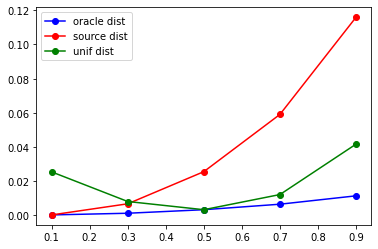

In [380]:
rhos = np.linspace(0.1, 0.9, num=5)

loss_oracle = evaluate_multi_domains(key, rhos, mix_prior_estimator_oracle)
loss_source = evaluate_multi_domains(key, rhos, mix_prior_estimator_source)
loss_unif = evaluate_multi_domains(key, rhos, mix_prior_estimator_unif)

plt.figure()
plt.plot(rhos, loss_oracle, 'bo-', label='oracle dist')
plt.plot(rhos, loss_source, 'ro-', label='source dist')
plt.plot(rhos, loss_unif, 'go-', label='unif dist')
plt.legend()